In [2]:
import numpy as np
import pandas as pd
import os
import random
from random import shuffle
import cv2
import time
import matplotlib.pyplot as plt
from glob import glob
%matplotlib inline


In [3]:
import keras
import tensorflow as tf 
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D,GlobalMaxPooling2D,AveragePooling2D
from tensorflow.keras.layers import Conv2DTranspose, MaxPooling2D, concatenate, AveragePooling2D, Dense, Flatten
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense,Input,Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img,img_to_array,ImageDataGenerator
from keras.optimizers import Adam
from keras.models import Model
from keras.regularizers import l2
from imutils import paths
from sklearn.model_selection import train_test_split

In [4]:
IMAGE_SIZE = (64, 64)

In [5]:
train_files = []
mask_files = glob('../Brain_MRI_Segmentation/kaggle_3m/*/*_mask*')

for i in mask_files:
    train_files.append(i.replace('_mask', ''))
  

In [6]:
df = pd.DataFrame({"image_path": train_files, "mask_path":mask_files})

def labels(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value:
        return 1
    else:
        return 0

df['mask'] = df["mask_path"].apply(lambda x: labels(x))

In [7]:
df

,image_path,mask_path,mask
0,../Brain_MRI_Segmentation/kaggle_3m\TCGA_CS_49...,../Brain_MRI_Segmentation/kaggle_3m\TCGA_CS_49...,0
1,../Brain_MRI_Segmentation/kaggle_3m\TCGA_CS_49...,../Brain_MRI_Segmentation/kaggle_3m\TCGA_CS_49...,1
2,../Brain_MRI_Segmentation/kaggle_3m\TCGA_CS_49...,../Brain_MRI_Segmentation/kaggle_3m\TCGA_CS_49...,1
3,../Brain_MRI_Segmentation/kaggle_3m\TCGA_CS_49...,../Brain_MRI_Segmentation/kaggle_3m\TCGA_CS_49...,1
4,../Brain_MRI_Segmentation/kaggle_3m\TCGA_CS_49...,../Brain_MRI_Segmentation/kaggle_3m\TCGA_CS_49...,1
...,...,...,...
3924,../Brain_MRI_Segmentation/kaggle_3m\TCGA_HT_A6...,../Brain_MRI_Segmentation/kaggle_3m\TCGA_HT_A6...,0
3925,../Brain_MRI_Segmentation/kaggle_3m\TCGA_HT_A6...,../Brain_MRI_Segmentation/kaggle_3m\TCGA_HT_A6...,0
3926,../Brain_MRI_Segmentation/kaggle_3m\TCGA_HT_A6...,../Brain_MRI_Segmentation/kaggle_3m\TCGA_HT_A6...,0
3927,../Brain_MRI_Segmentation/kaggle_3m\TCGA_HT_A6...,../Brain_MRI_Segmentation/kaggle_3m\TCGA_HT_A6...,0


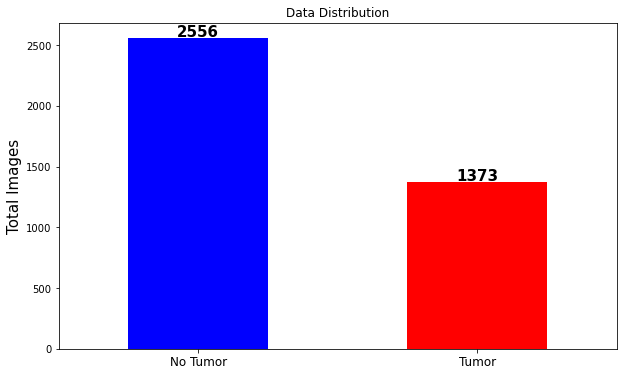

In [8]:
ax = df['mask'].value_counts().plot(kind='bar', stacked=True, figsize=(10,6), color=['blue', 'red'])
ax.set_title('Data Distribution')
ax.set_ylabel('Total Images', fontsize=15)
ax.set_xticklabels(['No Tumor', 'Tumor'], fontsize=12, rotation=0)
for i, rows in enumerate(df['mask'].value_counts().values):
    ax.annotate(int(rows), xy=(i, rows+12), ha='center', fontweight='bold', fontsize=15)

In [9]:
df['mask'].value_counts()

0    2556
1    1373
Name: mask, dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 92.2+ KB


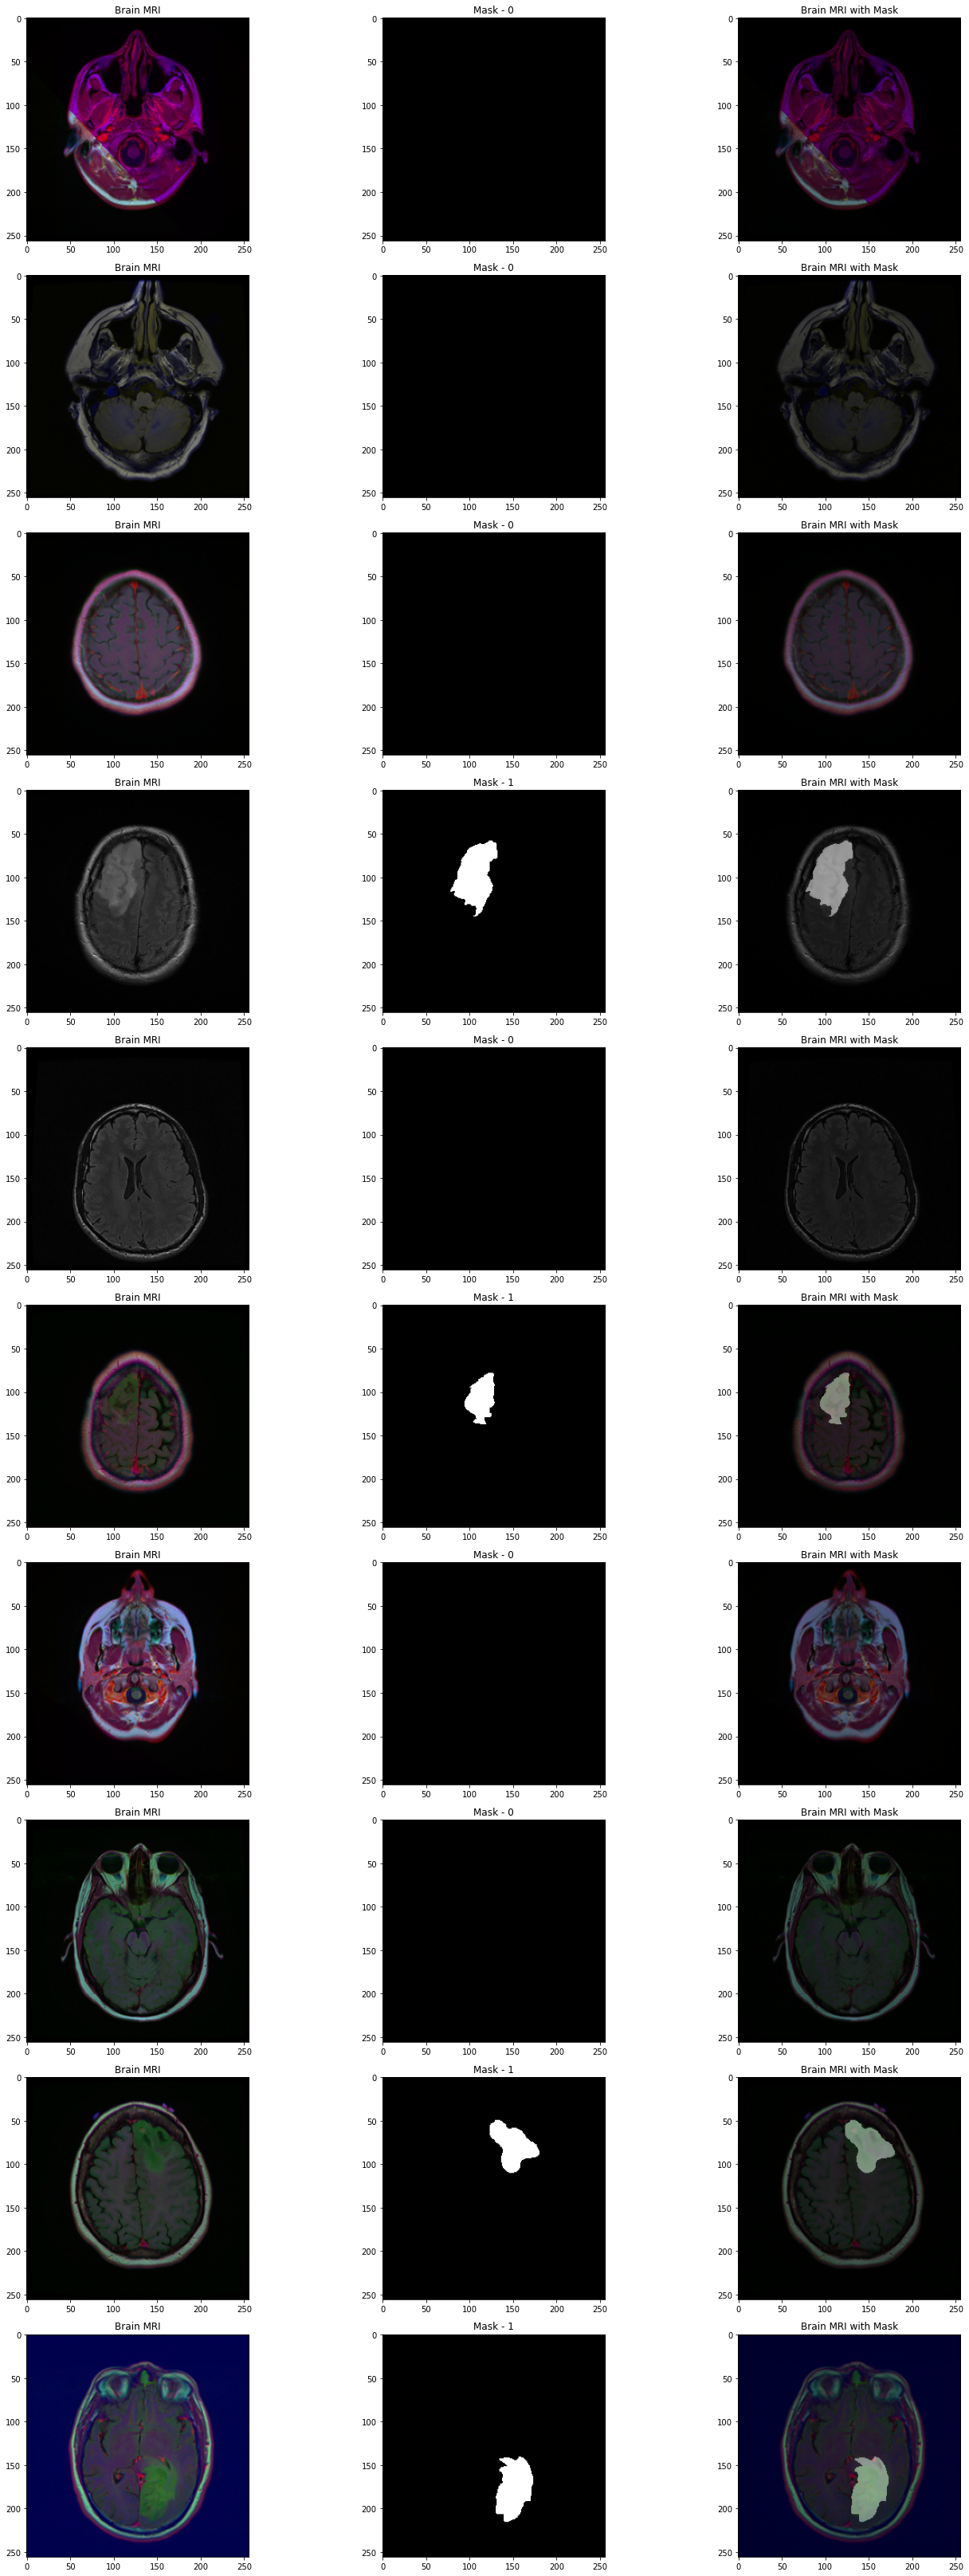

In [11]:
fig, ax = plt.subplots(10,3,figsize=(20,45))
for x in range(10):
    i = random.randint(0, len(df))
    img = cv2.imread(df['image_path'][i])
    mask = cv2.imread(df['mask_path'][i])
    ax[x][0].title.set_text("Brain MRI")
    ax[x][0].imshow(img)
    ax[x][1].title.set_text("Mask - " + str(df['mask'][i]))
    ax[x][1].imshow(mask)
    ax[x][2].title.set_text("Brain MRI with Mask")
    ax[x][2].imshow(img)
    ax[x][2].imshow(mask, alpha=0.4)
plt.tight_layout()

In [12]:
df['mask'] = df['mask'].apply(lambda x: str(x))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [13]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.15)
df_train, df_val = train_test_split(df_train, test_size=0.15)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(2838, 3)
(501, 3)
(590, 3)


In [14]:
df_train

,image_path,mask_path,mask
1043,../Brain_MRI_Segmentation/kaggle_3m\TCGA_DU_64...,../Brain_MRI_Segmentation/kaggle_3m\TCGA_DU_64...,0
2901,../Brain_MRI_Segmentation/kaggle_3m\TCGA_HT_74...,../Brain_MRI_Segmentation/kaggle_3m\TCGA_HT_74...,1
1330,../Brain_MRI_Segmentation/kaggle_3m\TCGA_DU_70...,../Brain_MRI_Segmentation/kaggle_3m\TCGA_DU_70...,1
396,../Brain_MRI_Segmentation/kaggle_3m\TCGA_DU_58...,../Brain_MRI_Segmentation/kaggle_3m\TCGA_DU_58...,0
119,../Brain_MRI_Segmentation/kaggle_3m\TCGA_CS_53...,../Brain_MRI_Segmentation/kaggle_3m\TCGA_CS_53...,0
...,...,...,...
1050,../Brain_MRI_Segmentation/kaggle_3m\TCGA_DU_64...,../Brain_MRI_Segmentation/kaggle_3m\TCGA_DU_64...,0
3855,../Brain_MRI_Segmentation/kaggle_3m\TCGA_HT_A6...,../Brain_MRI_Segmentation/kaggle_3m\TCGA_HT_A6...,0
1857,../Brain_MRI_Segmentation/kaggle_3m\TCGA_DU_81...,../Brain_MRI_Segmentation/kaggle_3m\TCGA_DU_81...,0
2428,../Brain_MRI_Segmentation/kaggle_3m\TCGA_FG_66...,../Brain_MRI_Segmentation/kaggle_3m\TCGA_FG_66...,0


In [15]:
df_test

,image_path,mask_path,mask
1651,../Brain_MRI_Segmentation/kaggle_3m\TCGA_DU_73...,../Brain_MRI_Segmentation/kaggle_3m\TCGA_DU_73...,0
645,../Brain_MRI_Segmentation/kaggle_3m\TCGA_DU_58...,../Brain_MRI_Segmentation/kaggle_3m\TCGA_DU_58...,1
244,../Brain_MRI_Segmentation/kaggle_3m\TCGA_CS_66...,../Brain_MRI_Segmentation/kaggle_3m\TCGA_CS_66...,1
26,../Brain_MRI_Segmentation/kaggle_3m\TCGA_CS_49...,../Brain_MRI_Segmentation/kaggle_3m\TCGA_CS_49...,1
1348,../Brain_MRI_Segmentation/kaggle_3m\TCGA_DU_70...,../Brain_MRI_Segmentation/kaggle_3m\TCGA_DU_70...,0
...,...,...,...
1114,../Brain_MRI_Segmentation/kaggle_3m\TCGA_DU_70...,../Brain_MRI_Segmentation/kaggle_3m\TCGA_DU_70...,1
3617,../Brain_MRI_Segmentation/kaggle_3m\TCGA_HT_81...,../Brain_MRI_Segmentation/kaggle_3m\TCGA_HT_81...,0
2125,../Brain_MRI_Segmentation/kaggle_3m\TCGA_DU_A5...,../Brain_MRI_Segmentation/kaggle_3m\TCGA_DU_A5...,1
2220,../Brain_MRI_Segmentation/kaggle_3m\TCGA_DU_A5...,../Brain_MRI_Segmentation/kaggle_3m\TCGA_DU_A5...,0


In [16]:
df_val

,image_path,mask_path,mask
3706,../Brain_MRI_Segmentation/kaggle_3m\TCGA_HT_A5...,../Brain_MRI_Segmentation/kaggle_3m\TCGA_HT_A5...,1
55,../Brain_MRI_Segmentation/kaggle_3m\TCGA_CS_49...,../Brain_MRI_Segmentation/kaggle_3m\TCGA_CS_49...,0
2053,../Brain_MRI_Segmentation/kaggle_3m\TCGA_DU_A5...,../Brain_MRI_Segmentation/kaggle_3m\TCGA_DU_A5...,0
178,../Brain_MRI_Segmentation/kaggle_3m\TCGA_CS_61...,../Brain_MRI_Segmentation/kaggle_3m\TCGA_CS_61...,1
378,../Brain_MRI_Segmentation/kaggle_3m\TCGA_DU_58...,../Brain_MRI_Segmentation/kaggle_3m\TCGA_DU_58...,1
...,...,...,...
1541,../Brain_MRI_Segmentation/kaggle_3m\TCGA_DU_73...,../Brain_MRI_Segmentation/kaggle_3m\TCGA_DU_73...,0
2492,../Brain_MRI_Segmentation/kaggle_3m\TCGA_FG_66...,../Brain_MRI_Segmentation/kaggle_3m\TCGA_FG_66...,1
2795,../Brain_MRI_Segmentation/kaggle_3m\TCGA_FG_A4...,../Brain_MRI_Segmentation/kaggle_3m\TCGA_FG_A4...,1
2978,../Brain_MRI_Segmentation/kaggle_3m\TCGA_HT_76...,../Brain_MRI_Segmentation/kaggle_3m\TCGA_HT_76...,0


In [17]:
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(64,64),
        seed=1):

    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "image_path",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask_path",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255.
    mask = mask / 255.
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

In [18]:
smooth=100

def dice_coef(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    return (2.0 * intersection + smooth) / (union + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

In [19]:
def unet(input_size=(64,64,3)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(64, (3, 3), padding='same')(inputs)
    bn1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, (3, 3), padding='same')(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation('relu')(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(128, (3, 3), padding='same')(pool1)
    bn2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, (3, 3), padding='same')(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation('relu')(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(256, (3, 3), padding='same')(pool2)
    bn3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, (3, 3), padding='same')(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation('relu')(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(512, (3, 3), padding='same')(pool3)
    bn4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, (3, 3), padding='same')(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation('relu')(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(1024, (3, 3), padding='same')(pool4)
    bn5 = Activation('relu')(conv5)
    conv5 = Conv2D(1024, (3, 3), padding='same')(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation('relu')(bn5)

    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn5), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), padding='same')(up6)
    bn6 = Activation('relu')(conv6)
    conv6 = Conv2D(512, (3, 3), padding='same')(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation('relu')(bn6)

    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bn6), conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), padding='same')(up7)
    bn7 = Activation('relu')(conv7)
    conv7 = Conv2D(256, (3, 3), padding='same')(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation('relu')(bn7)

    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bn7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), padding='same')(up8)
    bn8 = Activation('relu')(conv8)
    conv8 = Conv2D(128, (3, 3), padding='same')(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation('relu')(bn8)

    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(bn8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), padding='same')(up9)
    bn9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, (3, 3), padding='same')(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation('relu')(bn9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(bn9)

    return Model(inputs=[inputs], outputs=[conv10])

In [29]:
EPOCHS = 150
BATCH_SIZE = 64
learning_rate = 1e-4

In [30]:
model = unet(input_size=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
opt = Adam(lr=learning_rate)
model.compile(optimizer=opt, loss=dice_coef_loss, metrics=['accuracy','Precision','Recall',iou, dice_coef])
model.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_76 (Conv2D)              (None, 64, 64, 64)   1792        input_5[0][0]                    
__________________________________________________________________________________________________
activation_72 (Activation)      (None, 64, 64, 64)   0           conv2d_76[0][0]                  
__________________________________________________________________________________________________
conv2d_77 (Conv2D)              (None, 64, 64, 64)   36928       activation_72[0][0]              
_______________________________________________________________________________________

In [31]:
train_generator_args = dict(rotation_range=0.1,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            vertical_flip=True,
                            fill_mode='nearest')
train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=IMAGE_SIZE)
    
val_gen = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=IMAGE_SIZE)


callbacks = [ModelCheckpoint('BrainMRI_Seg.hdf5', verbose=0, save_best_only=True),
            EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=15)]

history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE, 
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data = val_gen,
                    validation_steps=len(df_val) / BATCH_SIZE)

Found 2838 validated image filenames.
Found 2838 validated image filenames.
Epoch 1/150
45/44 [==============================] - ETA: -7s - loss: 0.9395 - accuracy: 0.7557 - precision: 0.0377 - recall: 0.9479 - iou: 0.0327 - dice_coef: 0.0617Found 501 validated image filenames.
Found 501 validated image filenames.
45/44 [==============================] - 516s 11s/step - loss: 0.9395 - accuracy: 0.7557 - precision: 0.0377 - recall: 0.9479 - iou: 0.0327 - dice_coef: 0.0617 - val_loss: 0.9747 - val_accuracy: 0.9894 - val_precision: 0.5666 - val_recall: 0.3098 - val_iou: 0.0132 - val_dice_coef: 0.0252
Epoch 2/150
45/44 [==============================] - 590s 13s/step - loss: 0.8819 - accuracy: 0.9583 - precision: 0.1794 - recall: 0.8749 - iou: 0.0646 - dice_coef: 0.1186 - val_loss: 0.9760 - val_accuracy: 0.9887 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_iou: 0.0128 - val_dice_coef: 0.0241
Epoch 3/150
45/44 [==============================] - 588s 13s/step - loss: 0.8478 - ac

45/44 [==============================] - 454s 10s/step - loss: 0.1561 - accuracy: 0.9973 - precision: 0.8653 - recall: 0.8706 - iou: 0.7358 - dice_coef: 0.8442 - val_loss: 0.1571 - val_accuracy: 0.9969 - val_precision: 0.8846 - val_recall: 0.8482 - val_iou: 0.7319 - val_dice_coef: 0.8417
Epoch 55/150
45/44 [==============================] - 459s 10s/step - loss: 0.1495 - accuracy: 0.9974 - precision: 0.8681 - recall: 0.8779 - iou: 0.7451 - dice_coef: 0.8507 - val_loss: 0.1743 - val_accuracy: 0.9966 - val_precision: 0.8891 - val_recall: 0.8084 - val_iou: 0.7070 - val_dice_coef: 0.8234
Epoch 56/150
45/44 [==============================] - 452s 10s/step - loss: 0.1503 - accuracy: 0.9974 - precision: 0.8723 - recall: 0.8701 - iou: 0.7433 - dice_coef: 0.8493 - val_loss: 0.1585 - val_accuracy: 0.9969 - val_precision: 0.9095 - val_recall: 0.8196 - val_iou: 0.7308 - val_dice_coef: 0.8415
Epoch 57/150
45/44 [==============================] - 452s 10s/step - loss: 0.1439 - accuracy: 0.9975 - pre

Text(0.5, 1.0, 'Dice Coef graph')

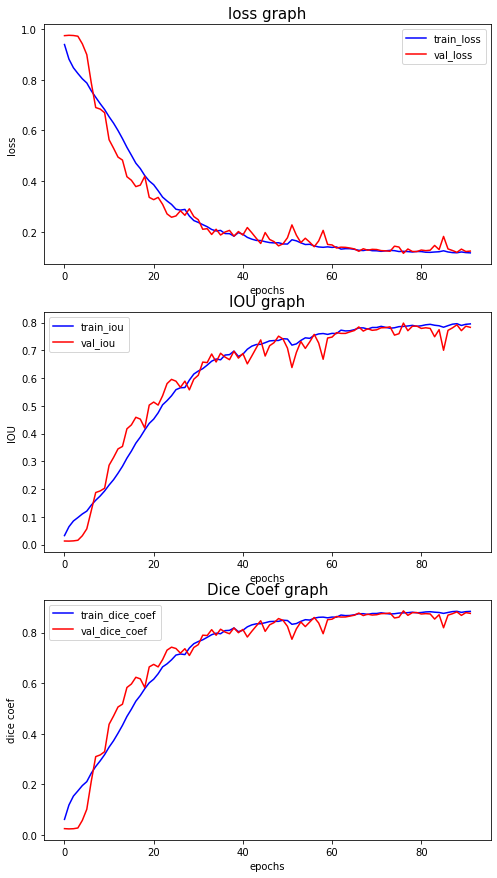

In [32]:
plt.figure(figsize=(8,15))
plt.subplot(3,1,1)
plt.plot(model.history.history['loss'], 'b-', label='train_loss')
plt.plot(model.history.history['val_loss'], 'r-', label='val_loss')
plt.legend(loc='best')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('loss graph', fontsize = 15)

plt.subplot(3,1,2)
plt.plot(model.history.history['iou'], 'b-', label='train_iou')
plt.plot(model.history.history['val_iou'], 'r-', label='val_iou')
plt.legend(loc='best')
plt.xlabel('epochs')
plt.ylabel('IOU')
plt.title('IOU graph', fontsize = 15)

plt.subplot(3,1,3)
plt.plot(model.history.history['dice_coef'], 'b-', label='train_dice_coef')
plt.plot(model.history.history['val_dice_coef'], 'r-', label='val_dice_coef')
plt.legend(loc='best')
plt.xlabel('epochs')
plt.ylabel('dice coef')
plt.title('Dice Coef graph', fontsize = 15)

In [33]:
test_gen = train_generator(df_test, BATCH_SIZE,
                                dict(),
                                target_size=IMAGE_SIZE)

In [34]:
results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE)
print("Test Accuracy: ",results[1])
print("Test Precision: ",results[2])
print("Test Recall: ",results[3])
print("Test IOU: ",results[4])
print("Test Dice Coefficent: ",results[5])

Found 590 validated image filenames.
Found 590 validated image filenames.
10/9 [================================] - 19s 2s/step - loss: 0.1320 - accuracy: 0.9976 - precision: 0.8933 - recall: 0.8632 - iou: 0.7655 - dice_coef: 0.8610
Test Accuracy:  0.997555673122406
Test Precision:  0.8932504057884216
Test Recall:  0.8632467985153198
Test IOU:  0.7654612064361572
Test Dice Coefficent:  0.8609663844108582


In [47]:
Y_pred = model.predict_generator(test_gen)
y_pred = np.argmax(Y_pred, axis=-1)

from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(test_gen.classes,y_pred)
sns.heatmap(cm, annot=True)
plt.savefig('confusion_matrix_U_Net.png')

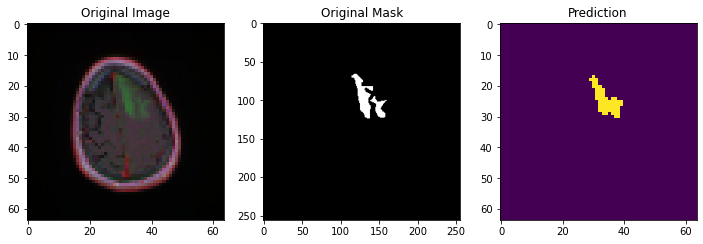

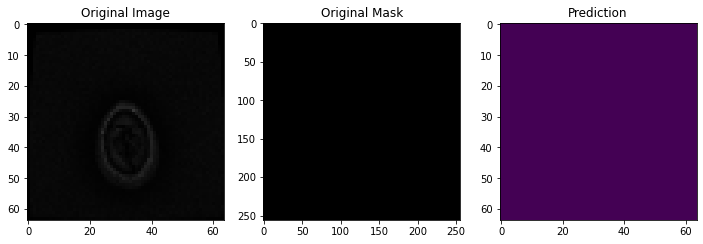

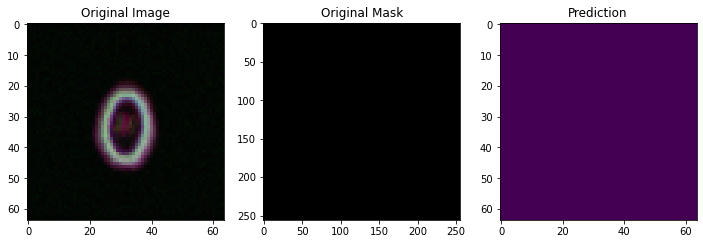

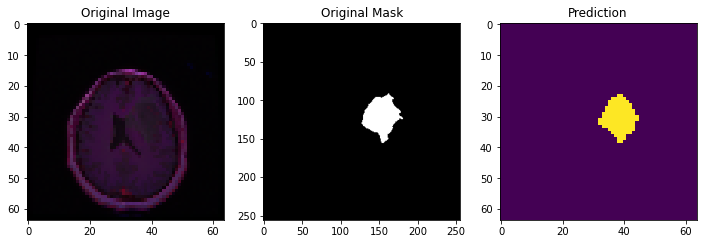

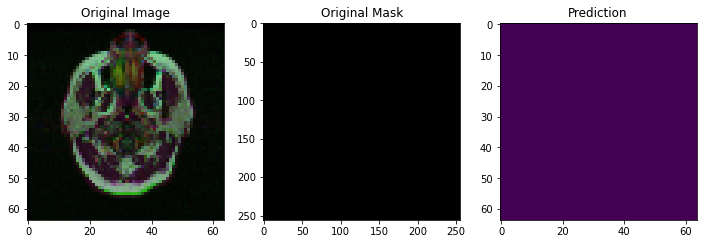

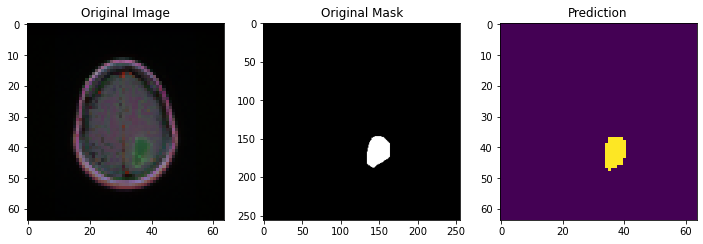

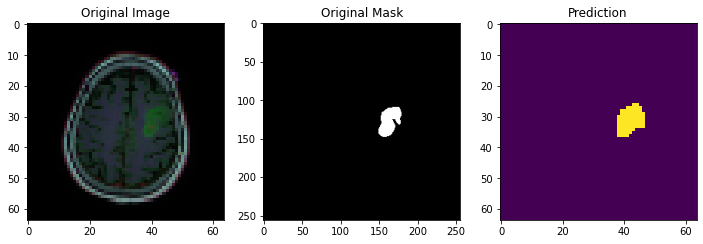

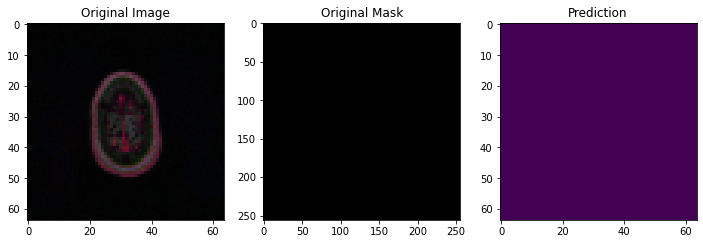

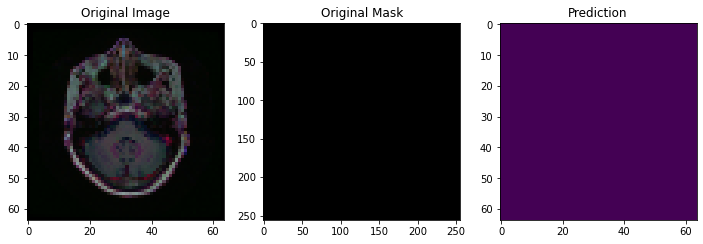

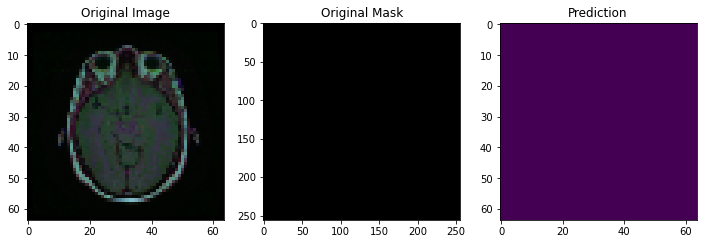

In [48]:
for i in range(10):
    index=np.random.randint(1,len(df_test.index))
    img = cv2.imread(df_test['image_path'].iloc[index])
    img = cv2.resize(img ,IMAGE_SIZE)
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask_path'].iloc[index])))
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .5)
    plt.title('Prediction')
    plt.show()

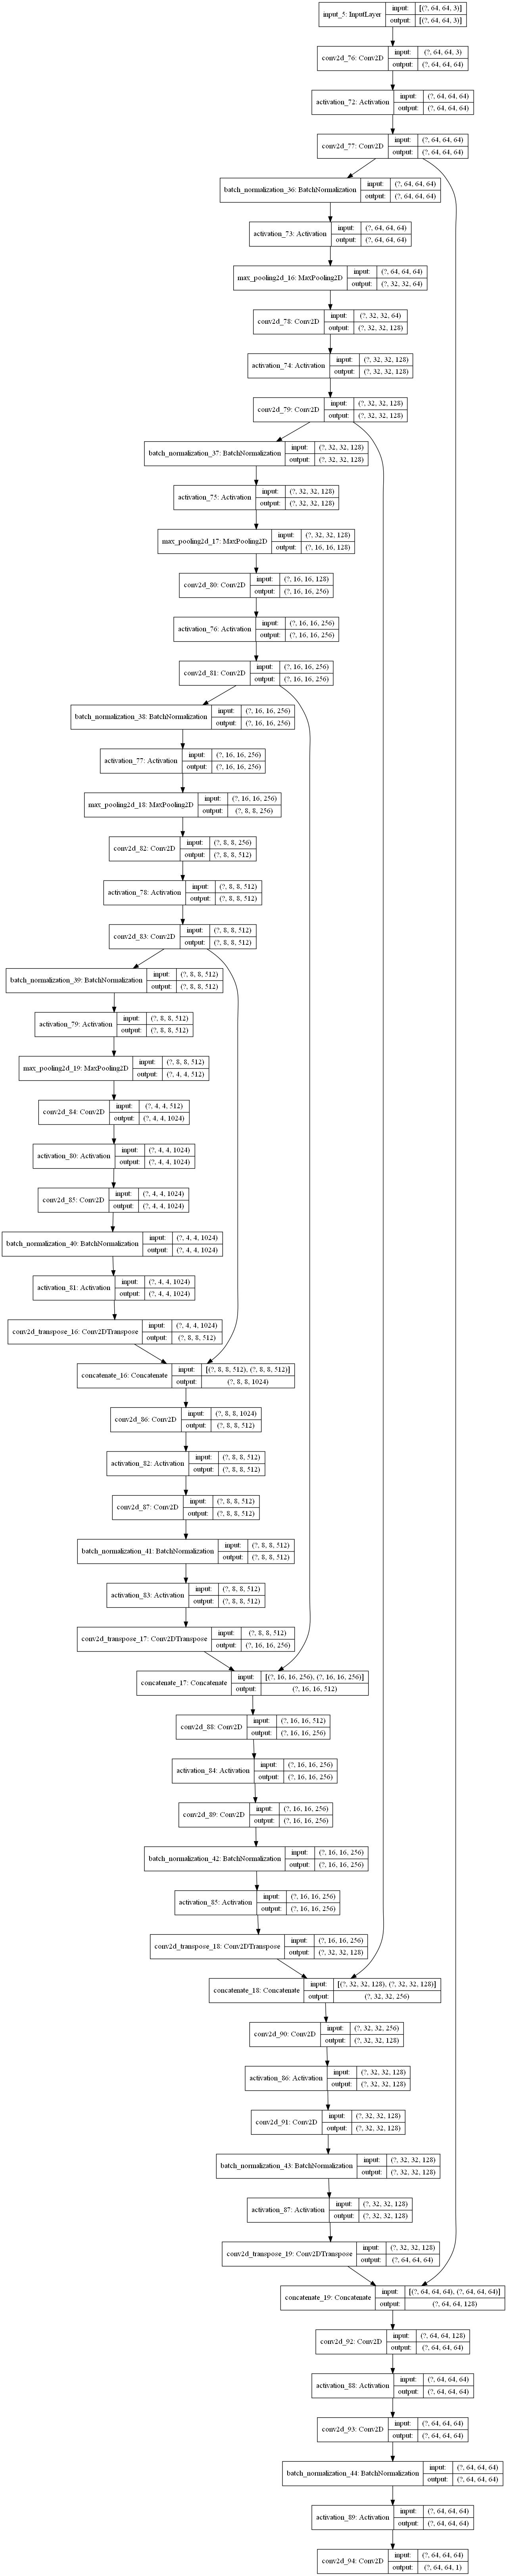

In [49]:
from keras.utils import plot_model
plot_model(model,to_file='U_Net_model.png',show_shapes=True)